###**Ambil Pustaka**

In [2]:
!pip install google-play-scraper
!pip install sastrawi
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00


In [69]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import datetime as dt
import re
import string

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Collecting Data**

In [68]:
from google_play_scraper import app, reviews, Sort, reviews_all
scrapreview = reviews_all(
    'com.Info_BMKG',          # ID aplikasi
    lang='id',             # Bahasa ulasan (default: 'en')
    country='id',          # Negara (default: 'us')
    sort=Sort.MOST_RELEVANT, # Urutan ulasan (default: Sort.MOST_RELEVANT)
)
review_app_df = pd.DataFrame(scrapreview)
# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = review_app_df.shape
#simpan ke csv
review_app_df.to_csv('ulasan.csv', index=False)


In [5]:
review_app_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,4c4e4c90-9e6b-4743-9b5f-7b543e01a2a4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Update terakhir kok mau buka info citra sateli...,4,19,3.4.3,2025-01-31 14:11:12,None,NaT,3.4.3
1,e7e4a513-4737-44d7-a162-6caf4a8b762a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sayang sekali aplikasinya di buka sangat berat...,4,74,3.4.2,2024-12-14 12:08:45,None,NaT,3.4.2
2,378c8349-ade4-4f6b-afa9-d887b6c30347,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"muncul notifikasi,pemberitahuan izinkan mengak...",4,2,3.4.3,2025-01-31 11:26:18,None,NaT,3.4.3
3,8e414440-2cd3-4923-8924-663955d50a3d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Lokasi yang tertera di bagian cuaca dan gempa ...,2,13,3.4.3,2025-01-16 04:24:37,None,NaT,3.4.3
4,52812c67-9311-4b62-a553-cc422d5f85bc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Setelah update makin lelet tiap dibuka. Lokasi...,1,19,3.4.3,2025-01-16 11:16:17,None,NaT,3.4.3


###**Cleaning data**

In [70]:
review_app_df = pd.read_csv('/content/ulasan.csv')
review_app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20815 entries, 0 to 20814
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20815 non-null  object
 1   userName              20815 non-null  object
 2   userImage             20815 non-null  object
 3   content               20805 non-null  object
 4   score                 20815 non-null  int64 
 5   thumbsUpCount         20815 non-null  int64 
 6   reviewCreatedVersion  14568 non-null  object
 7   at                    20815 non-null  object
 8   replyContent          261 non-null    object
 9   repliedAt             261 non-null    object
 10  appVersion            14568 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


In [71]:
unused_head = ['reviewId','userName','userImage','score','thumbsUpCount','reviewCreatedVersion',
               'at','replyContent','repliedAt','appVersion']
for head in unused_head:
  review_app_df.drop(head, axis=1, inplace=True)

review_app_df.head()

,content
0,"Update terakhir kok mau buka info citra satelit jadi susah, jg menu lainnya. Awal saya kira karena kapasitas memori HP, setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama. Mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support, terimakasih."
1,"Sayang sekali aplikasinya di buka sangat berat, loadingnya lama buat masuk interface awal. Semoga dapat diperbaiki lagi. Saran, agar lebih menarik tambahkan fitur widget min, krn saya kira udah lengkap infonya tinggal kembangin lagi"
2,"muncul notifikasi,pemberitahuan izinkan mengakses lokasi.,padahal sudah di izinkan., tapi tetap pemeritahuannya tetap muncul., dan juga peta guncangan tak bisa di akses., sudah 2 hp saya coba., tetap kerusakan ini ada..,"
3,"Lokasi yang tertera di bagian cuaca dan gempa bumi sering berubah sendiri padahal GPS di gawai sudah dinyalakan. Meski sudah diubah lokasinya supaya sesuai, tapi lokasi yang sudah diperbaiki malah kembali ke lokasi yang salah. Hal ini bukan cuma 1-2 kali, tapi cukup sering terjadi dan ini cukup mengganggu. Selain itu, kalau ada peringatan gempa bumi sebaiknya juga dimunculkan suaranya di aplikasi, seperti di web inatews bmkg."
4,"Setelah update makin lelet tiap dibuka. Lokasi kenapa selalu gunung sahari jakarta,tidak sesuai dengan setingan lokasi default yg kita pilih sendiri sebelum di update. Kembalikan tampilan apk seperti dahulu"


In [72]:
clean_df = review_app_df.dropna()
clean_df.drop_duplicates().reset_index(drop=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20805 entries, 0 to 20809
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20805 non-null  object
dtypes: object(1)
memory usage: 325.1+ KB


In [73]:
def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
  text = re.sub(r'RT[\s]', '', text)        # remove RT
  text = re.sub(r"http\S+", '', text)       # remove link
  text = re.sub(r'[0-9]+', '', text)        # remove numbers
  text = re.sub(r'[^\w\s]', '', text)       # remove numbers


  text = text.replace('\n', ' ')            # replace new line into space
  text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
  text = text.strip(' ')                    # remove characters space from both left and right text
  return text

def casefoldigText(text):
  text = text.lower()
  return text

def tokenizingText(text):
  # Tokenizing or splitting a string, text into a list of tokens
  text = word_tokenize(text)
  return text

def lemmatingText(text):
  wnl  = WordNetLemmatizer()

  # Memecah teks menjadi daftar kata
  words = text.split()

  lemmatized_words = [wnl.lemmatize(word, pos="v") for word in words]
  lemmatized_text = ' '.join(lemmatized_words)

  return lemmatized_text

def filteringText(text):
  factory = StopWordRemoverFactory()
  listStopwords = factory.get_stop_words()
  filtered = []
  for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
  text = filtered
  return text

  clean_text = stopwords.remove(text)
  return clean_text

get_slangs = requests.get('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/refs/heads/master/combined_slang_words.txt')
if get_slangs.status_code == 200:
    slangwords = json.loads(get_slangs.text)
else:
    print("Gagal Ambil Data")

def fix_slangwords(text):
  words = text.split()
  fixed_words = []

  for word in words:
    if word.lower() in slangwords:
      fixed_words.append(slangwords[word.lower()])
    else:
      fixed_words.append(word)

  fixed_text = ' '.join(fixed_words)
  return fixed_text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [74]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldigText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_lemmatized'] = clean_df['text_slangwords'].apply(lemmatingText)
clean_df['text_tokenizingText'] =clean_df['text_lemmatized'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [75]:
clean_df

,content,text_clean,text_casefoldingText,text_slangwords,text_lemmatized,text_tokenizingText,text_stopword,text_akhir
0,"Update terakhir kok mau buka info citra satelit jadi susah, jg menu lainnya. Awal saya kira karena kapasitas memori HP, setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama. Mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support, terimakasih.",Update terakhir kok mau buka info citra satelit jadi susah jg menu lainnya Awal saya kira karena kapasitas memori HP setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama Mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support terimakasih,update terakhir kok mau buka info citra satelit jadi susah jg menu lainnya awal saya kira karena kapasitas memori hp setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support terimakasih,update terakhir kok mau buka informasi citra satelit jadi susah juga menu lainnya awal saya kira karena kapasitas memori hp setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support terimakasih,update terakhir kok mau buka informasi citra satelit jadi susah juga menu lainnya awal saya kira karena kapasitas memori hp setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support terimakasih,"[update, terakhir, kok, mau, buka, informasi, citra, satelit, jadi, susah, juga, menu, lainnya, awal, saya, kira, karena, kapasitas, memori, hp, setelah, hpus, beberapa, aplikasi, dan, memori, penyimpanan, hasilnya, kok, sama, mohon, pembaharuan, aplikasi, ttp, memperhatikan, bagaimana, agar, semua, gadged, ttp, bisa, support, terimakasih]","[update, terakhir, kok, mau, buka, informasi, citra, satelit, jadi, susah, menu, lainnya, awal, kira, kapasitas, memori, hp, hpus, beberapa, aplikasi, memori, penyimpanan, hasilnya, kok, sama, mohon, pembaharuan, aplikasi, ttp, memperhatikan, bagaimana, semua, gadged, ttp, support, terimakasih]",update terakhir kok mau buka informasi citra satelit jadi susah menu lainnya awal kira kapasitas memori hp hpus beberapa aplikasi memori penyimpanan hasilnya kok sama mohon pembaharuan aplikasi ttp memperhatikan bagaimana semua gadged ttp support terimakasih
1,"Sayang sekali aplikasinya di buka sangat berat, loadingnya lama buat masuk interface awal. Semoga dapat diperbaiki lagi. Saran, agar lebih menarik tambahkan fitur widget min, krn saya kira udah lengkap infonya tinggal kembangin lagi",Sayang sekali aplikasinya di buka sangat berat loadingnya lama buat masuk interface awal Semoga dapat diperbaiki lagi Saran agar lebih menarik tambahkan fitur widget min krn saya kira udah lengkap infonya tinggal kembangin lagi,sayang sekali aplikasinya di buka sangat berat loadingnya lama buat masuk interface awal semoga dapat diperbaiki lagi saran agar lebih menarik tambahkan fitur widget min krn saya kira udah lengkap infonya tinggal kembangin lagi,sayang sekali aplikasinya di buka sangat berat loadingnya lama buat masuk interface awal semoga dapat diperbaiki lagi saran agar lebih menarik tambahkan fitur widget min karena saya kira sudah lengkap infonya tinggal kembangin lagi,sayang sekali aplikasinya di buka sangat berat loadingnya lama buat masuk interface awal semoga dapat diperbaiki lagi saran agar lebih menarik tambahkan fitur widget min karena saya kira sudah lengkap infonya tinggal kembangin lagi,"[sayang, sekali, aplikasinya, di, buka, sangat, berat, loadingnya, lama, buat, masuk, interface, awal, semoga, dapat, diperbaiki, lagi, saran, agar, lebih, menarik, tambahkan, fitur, widget, min, karena, saya, kira, sudah, lengkap, infonya, tinggal, kembangin, lagi]","[sayang, sekali, aplikasinya, buka, sangat, berat, loadingnya, lama, buat, 

In [76]:
clean_df.tail(200)

,content,text_clean,text_casefoldingText,text_slangwords,text_lemmatized,text_tokenizingText,text_stopword,text_akhir
20610,lumayan akurat,lumayan akurat,lumayan akurat,lumayan akurat,lumayan akurat,"[lumayan, akurat]","[lumayan, akurat]",lumayan akurat
20611,Lebih baik,Lebih baik,lebih baik,lebih baik,lebih baik,"[lebih, baik]","[lebih, baik]",lebih baik
20612,Jaya selalu,Jaya selalu,jaya selalu,jaya selalu,jaya selalu,"[jaya, selalu]","[jaya, selalu]",jaya selalu
20613,Sangat bermanfaat,Sangat bermanfaat,sangat bermanfaat,sangat bermanfaat,sangat bermanfaat,"[sangat, bermanfaat]","[sangat, bermanfaat]",sangat bermanfaat
20614,good bagus,good bagus,good bagus,good bagus,good bagus,"[good, bagus]","[good, bagus]",good bagus
...,...,...,...,...,...,...,...,...
20805,Ok..,Ok,ok,ok,ok,[ok],[],
20806,Mantap....,Mantap,mantap,mantap,mantap,[mantap],[mantap],mantap
20807,Mantap....,Mantap,mantap,mantap,mantap,[mantap],[mantap],mantap
20808,👍,,,,,[],[],


In [77]:
# delete last text that unrellevant
clean_df.dropna()
ready_df = clean_df.drop(clean_df.tail(200).index)

###**Labelling**

####**Labelling dengan Lexicon Indonesia**

In [78]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
   print("Failed to fetch negative lexicon data")

In [79]:
def sentiment_analysis_lexicon_indonesia(text):
  score = 0

  for word in text:
     if (word in lexicon_positive):
      score = score + lexicon_positive[word]

  for word in text:
    if (word in lexicon_negative):
      score = score + lexicon_negative[word]

  polarity=''
  if (score > 0):
    polarity = 'positive'
  elif (score < 0):
    polarity = 'negative'
  else:
    polarity = 'neutral'
  return score, polarity

In [80]:
results = ready_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
ready_df['label_score'] = results[0]
ready_df['label'] = results[1]

In [81]:
print(ready_df['label'].value_counts())

label
positive    7909
negative    7723
neutral     4973
Name: count, dtype: int64


In [82]:
ready_df

,content,text_clean,text_casefoldingText,text_slangwords,text_lemmatized,text_tokenizingText,text_stopword,text_akhir,label_score,label
0,"Update terakhir kok mau buka info citra satelit jadi susah, jg menu lainnya. Awal saya kira karena kapasitas memori HP, setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama. Mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support, terimakasih.",Update terakhir kok mau buka info citra satelit jadi susah jg menu lainnya Awal saya kira karena kapasitas memori HP setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama Mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support terimakasih,update terakhir kok mau buka info citra satelit jadi susah jg menu lainnya awal saya kira karena kapasitas memori hp setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support terimakasih,update terakhir kok mau buka informasi citra satelit jadi susah juga menu lainnya awal saya kira karena kapasitas memori hp setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support terimakasih,update terakhir kok mau buka informasi citra satelit jadi susah juga menu lainnya awal saya kira karena kapasitas memori hp setelah hpus beberapa aplikasi dan memori penyimpanan hasilnya kok sama mohon pembaharuan aplikasi ttp memperhatikan bagaimana agar semua gadged ttp bisa support terimakasih,"[update, terakhir, kok, mau, buka, informasi, citra, satelit, jadi, susah, juga, menu, lainnya, awal, saya, kira, karena, kapasitas, memori, hp, setelah, hpus, beberapa, aplikasi, dan, memori, penyimpanan, hasilnya, kok, sama, mohon, pembaharuan, aplikasi, ttp, memperhatikan, bagaimana, agar, semua, gadged, ttp, bisa, support, terimakasih]","[update, terakhir, kok, mau, buka, informasi, citra, satelit, jadi, susah, menu, lainnya, awal, kira, kapasitas, memori, hp, hpus, beberapa, aplikasi, memori, penyimpanan, hasilnya, kok, sama, mohon, pembaharuan, aplikasi, ttp, memperhatikan, bagaimana, semua, gadged, ttp, support, terimakasih]",update terakhir kok mau buka informasi citra satelit jadi susah menu lainnya awal kira kapasitas memori hp hpus beberapa aplikasi memori penyimpanan hasilnya kok sama mohon pembaharuan aplikasi ttp memperhatikan bagaimana semua gadged ttp support terimakasih,2,positive
1,"Sayang sekali aplikasinya di buka sangat berat, loadingnya lama buat masuk interface awal. Semoga dapat diperbaiki lagi. Saran, agar lebih menarik tambahkan fitur widget min, krn saya kira udah lengkap infonya tinggal kembangin lagi",Sayang sekali aplikasinya di buka sangat berat loadingnya lama buat masuk interface awal Semoga dapat diperbaiki lagi Saran agar lebih menarik tambahkan fitur widget min krn saya kira udah lengkap infonya tinggal kembangin lagi,sayang sekali aplikasinya di buka sangat berat loadingnya lama buat masuk interface awal semoga dapat diperbaiki lagi saran agar lebih menarik tambahkan fitur widget min krn saya kira udah lengkap infonya tinggal kembangin lagi,sayang sekali aplikasinya di buka sangat berat loadingnya lama buat masuk interface awal semoga dapat diperbaiki lagi saran agar lebih menarik tambahkan fitur widget min karena saya kira sudah lengkap infonya tinggal kembangin lagi,sayang sekali aplikasinya di buka sangat berat loadingnya lama buat masuk interface awal semoga dapat diperbaiki lagi saran agar lebih menarik tambahkan fitur widget min karena saya kira sudah lengkap infonya tinggal kembangin lagi,"[sayang, sekali, aplikasinya, di, buka, sangat, berat, loadingnya, lama, buat, masuk, interface, awal, semoga, dapat, diperbaiki, lagi, saran, agar, lebih, menarik, tambahkan, fitur, widget, min, karena, saya, kira, sudah, lengkap, infonya, tinggal, kembangin, lagi]","[sayang, sekali, aplikasinya, buka, sangat, be

###**Eksplorasi Data**

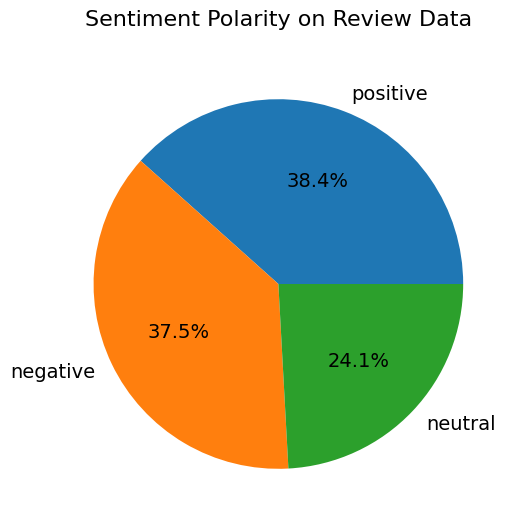

In [83]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'ready_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in ready_df['label'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'ready_df' dan menyimpannya dalam list 'labels'.
labels = list(ready_df['label'].value_counts().index)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [84]:
pd.set_option('display.max_colwidth', 3000)
positive_sentiments = ready_df[ready_df['label']=='positive']
positive_sentiments = positive_sentiments[['text_akhir','label','text_stopword']]
positive_sentiments = positive_sentiments.reset_index(drop=True)
positive_sentiments.index += 1

In [85]:
pd.set_option('display.max_colwidth', 3000)
negative_sentiments = ready_df[ready_df['label']=='negative']
negative_sentiments = negative_sentiments[['text_akhir','label','text_stopword']]
negative_sentiments = negative_sentiments.reset_index(drop=True)
negative_sentiments.index += 1

In [86]:
pd.set_option('display.max_colwidth', 3000)
neutral_sentiments = ready_df[ready_df['label']=='neutral']
neutral_sentiments = neutral_sentiments[['text_akhir','label','text_stopword']]
neutral_sentiments = neutral_sentiments.reset_index(drop=True)
neutral_sentiments.index += 1

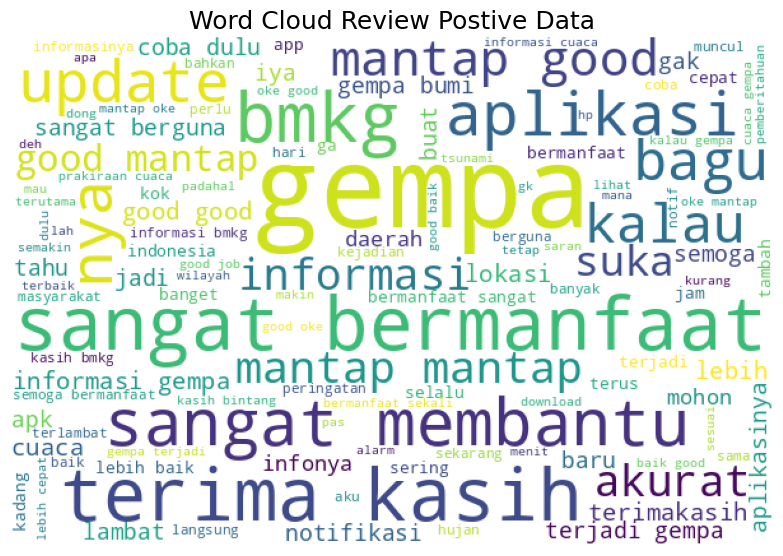

In [87]:
list_words = ''
for reviews in positive_sentiments['text_stopword']:
  for word in reviews:
    list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400,background_color='white', min_font_size=10).generate(list_words)
fig,ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Review Postive Data', fontsize = 18)

ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()


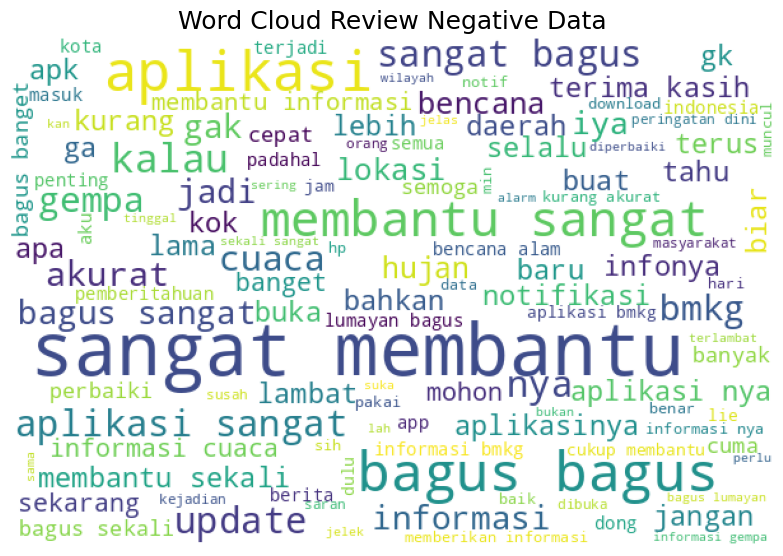

In [88]:
list_words = ''
for reviews in negative_sentiments['text_stopword']:
  for word in reviews:
    list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400,background_color='white', min_font_size=10).generate(list_words)
fig,ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Review Negative Data', fontsize = 18)

ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

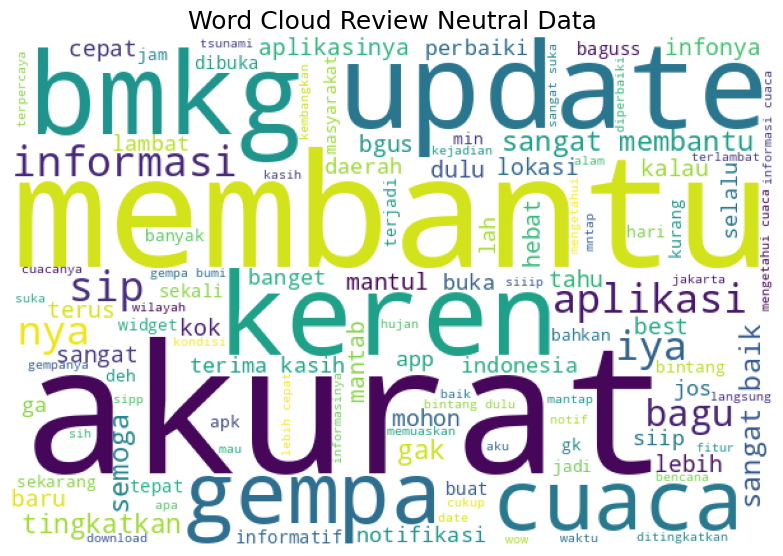

In [89]:
list_words = ''
for reviews in neutral_sentiments['text_stopword']:
  for word in reviews:
    list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400,background_color='white', min_font_size=10).generate(list_words)
fig,ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Review Neutral Data', fontsize = 18)

ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

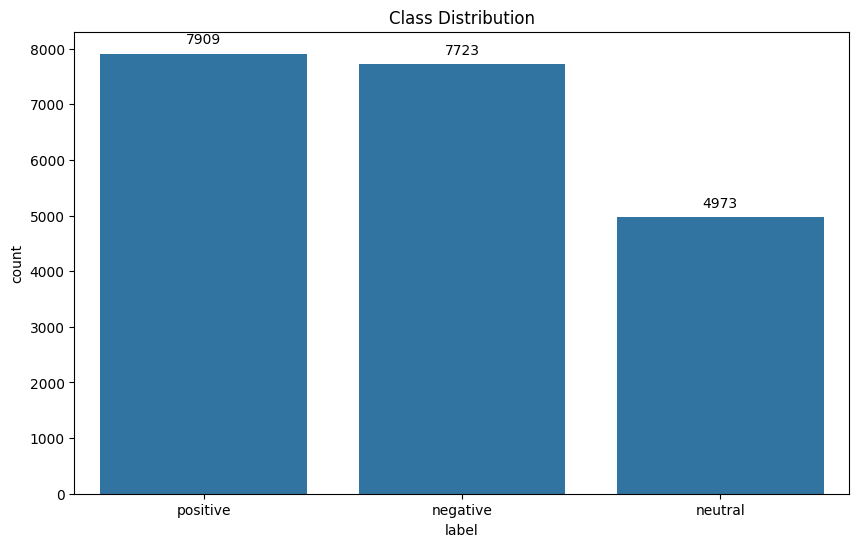

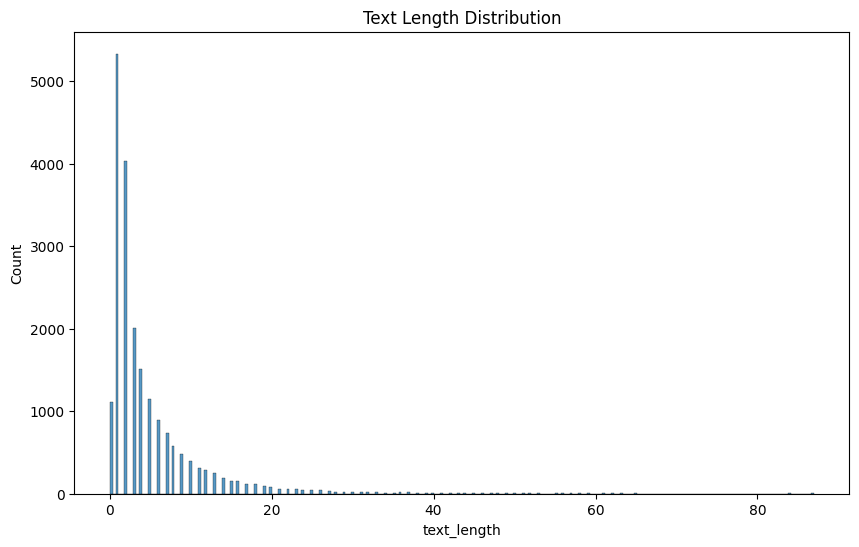

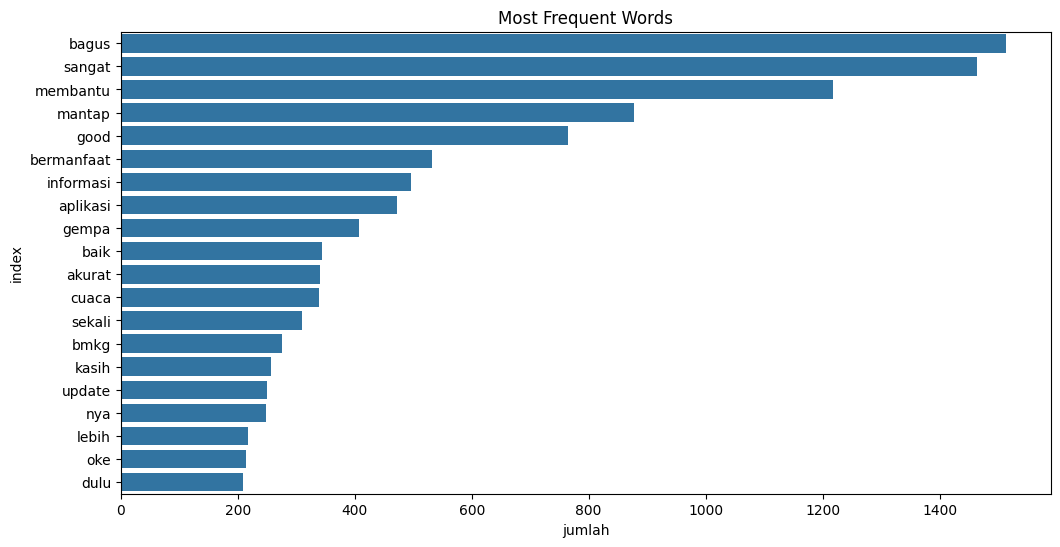

In [90]:
plt.figure(figsize=(10, 6))

class_dist_plot = sns.countplot(x='label', data=ready_df)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

plt.figure(figsize=(10, 6))

ready_df['text_length'] = ready_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(ready_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

plt.figure(figsize=(12, 6))


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(ready_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()


###**Ekstraksi Fitur**

**TF-IDF**

In [91]:
X = ready_df['text_akhir']
y = ready_df['label']

In [92]:
tfidf = TfidfVectorizer(max_features=200, min_df=100, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

features_df

,adanya,aku,akurat,alam,alarm,apa,apk,aplikasi,aplikasinya,app,...,terlambat,terus,tingkatkan,top,tsunami,update,waktu,waspada,widget,wilayah
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.331827,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.202460,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.224182,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.283447,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111679,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.290218,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.467411,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20600,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
20601,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
20602,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
20603,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


**Word2Vec**

In [93]:
tokenized_data = [word_tokenize(sentence.lower()) for sentence in X]
model_X = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)
X_word2vec = model_X.wv

In [94]:
def get_average_word2vec(sentence, model):
    # Mengambil vektor rata-rata dari setiap kata dalam kalimat
    words = sentence
    feature_vector = []
    for word in words:
        if word in model:
            feature_vector.append(model[word])
    # Mengambil rata-rata vektor kata-kata dalam kalimat
    if feature_vector:
        return np.mean(feature_vector, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return vector kosong jika tidak ada kata yang cocok

# Ekstraksi fitur untuk setiap kalimat
feature_matrix = [get_average_word2vec(sentence, X_word2vec) for sentence in X]



###**Pemodelan**

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

**1. Random Forest with W2vec**

In [96]:
X_w2v = np.array(feature_matrix)
Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_w2v, y, test_size=0.3, random_state=42)

In [97]:
# Membuat objek model Random Forest
random_forest_w2v = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest_w2v.fit(Xw_train, yw_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest_w2v.predict(Xw_train)
y_pred_test_rf = random_forest_w2v.predict(Xw_test)

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, yw_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, yw_test)

# Menampilkan akurasi
print(f"Random Forest - accuracy_train: {accuracy_train_rf*100:.2f} %")
print(f"Random Forest - accuracy_test: {accuracy_test_rf*100:.2f} %")

Random Forest - accuracy_train: 99.50 %
Random Forest - accuracy_test: 73.41 %


**2. Random Forest with TF-IDF**

In [98]:
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [99]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(Xt_train.toarray(), yt_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(Xt_train.toarray())
y_pred_test_rf = random_forest.predict(Xt_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, yt_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, yt_test)

# Menampilkan akurasi
print(f"Random Forest - accuracy_train: {accuracy_train_rf*100:.2f} %")
print(f"Random Forest - accuracy_test: {accuracy_test_rf*100:.2f} %")

Random Forest - accuracy_train: 94.42 %
Random Forest - accuracy_test: 85.68 %


**3. Logistic Regression with TF-IDF**

In [100]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(Xt_train.toarray(), yt_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(Xt_train.toarray())
y_pred_test_lr = logistic_regression.predict(Xt_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, yt_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, yt_test)

# Menampilkan akurasi
print(f"Logistic Regression - accuracy_train: {accuracy_train_lr*100:.2f} %")
print(f"Logistic Regression - accuracy_test: {accuracy_test_lr*100:.2f} %")

Logistic Regression - accuracy_train: 86.12 %
Logistic Regression - accuracy_test: 86.63 %


####**Inference**

In [102]:
def preprocess_text(text):
  text = text.lower()
  return text
def text_to_w2vec(text,model):
  words = text.split()
  word_vector = [model[word] for word in words if word in model]
  if len(word_vector) > 0:
    return np.mean(word_vector, axis=0)
  else:
    return np.zeros(model.vector_size)

sample_text = ["Sayang sekali, ngaco","Luar biasa mantap aplikasinya","Biasa aja"]
new_clean_sample = [preprocess_text(text) for text in sample_text]
new_tfidf_vec = tfidf.transform(new_clean_sample)
new_w2vec = np.array([text_to_w2vec(text,X_word2vec) for text in new_clean_sample])


In [103]:
RFW_predict = random_forest_w2v.predict(new_w2vec)
RFT_predict = random_forest.predict(new_tfidf_vec)
LR_predict = logistic_regression.predict(new_tfidf_vec)
print("Prediksi Sentimen (Random Forest with W2Vec):", RFW_predict)
print("Prediksi Sentimen (Random Forest TFIDF):", RFT_predict)
print("Prediksi Sentimen (Logistic Regression TFIDF):", LR_predict)

Prediksi Sentimen (Random Forest with W2Vec): ['neutral' 'neutral' 'neutral']
Prediksi Sentimen (Random Forest TFIDF): ['negative' 'positive' 'neutral']
Prediksi Sentimen (Logistic Regression TFIDF): ['negative' 'positive' 'neutral']
